In [1]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [2]:
!gpustat

phoebe                         Tue Jun 21 00:47:43 2022  470.103.01
[0] NVIDIA GeForce GTX 1080 Ti | 38'C,  33 % |  1339 / 11178 MB | rmth(1335M)
[1] NVIDIA GeForce GTX 1080 Ti | 21'C,   0 % |     4 / 11178 MB |
[2] NVIDIA GeForce GTX 1080 Ti | 21'C,   0 % |     1 / 11178 MB |
[3] NVIDIA GeForce GTX 1080 Ti | 21'C,   0 % |     1 / 11178 MB |
[4] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[5] NVIDIA GeForce GTX 1080 Ti | 21'C,   0 % |     1 / 11178 MB |
[6] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[7] NVIDIA GeForce GTX 1080 Ti | 18'C,   0 % |     1 / 11178 MB |


In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [5]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [6]:
np.shape(np.array([0,10,2,3]))

(4,)

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [8]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [9]:
chart = [ [ ['05p', 'onlyBlosum', 20], ['1p', 'onlyBlosum', 20],  ['5p', 'onlyBlosum', 20], ['25p', 'onlyBlosum', 20], ['50p', 'onlyBlosum', 20], ['75p', 'onlyBlosum', 20], ['100p', 'onlyBlosum', 20]],
[ ['05p', 'onlyEmbedding', 4], ['1p', 'onlyEmbedding', 4],  ['5p', 'onlyEmbedding', 4], ['25p', 'onlyEmbedding', 4], ['50p', 'onlyEmbedding', 4], ['75p', 'onlyEmbedding', 4], ['100p', 'onlyEmbedding', 4]],
[ ['05p', 'onlyEmbedding', 20], ['1p', 'onlyEmbedding', 20],  ['5p', 'onlyEmbedding', 20], ['25p', 'onlyEmbedding', 20], ['50p', 'onlyEmbedding', 20], ['75p', 'onlyEmbedding', 20], ['100p', 'onlyEmbedding', 20]],    
[ ['05p', 'onlyEmbedding', 32], ['1p', 'onlyEmbedding', 32],  ['5p', 'onlyEmbedding', 32], ['25p', 'onlyEmbedding', 32], ['50p', 'onlyEmbedding', 32], ['75p', 'onlyEmbedding', 32],  ['100p', 'onlyEmbedding', 32]],
[ ['05p', 'onlyEmbedding', 64], ['1p', 'onlyEmbedding', 64],  ['5p', 'onlyEmbedding', 64], ['25p', 'onlyEmbedding', 64], ['50p', 'onlyEmbedding', 64], ['75p', 'onlyEmbedding', 64], ['100p', 'onlyEmbedding', 64]]  ]

In [10]:
size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}

In [11]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [12]:
pep_max_len = 14
hla_max_len = 34

tgt_len = pep_max_len + hla_max_len

d_ff = 512
n_layers, n_heads = 1, 3

batch_size = 1024
epochs = 25
threshold = 0.5

downsample = False
downsample_id = 6

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

model_abbr = 'FFNN'

id_blosum = 'OF_TData_pad14_{}_{}_hlac'
id_emb = 'OF_TData_pad14_{}_{}'
    
save_attn = False

In [13]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device('cuda')
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)

    def forward(self, pep_inputs, hla_inputs, pep_to_pad):
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
        enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1)
        dec_outputs = enc_outputs.view(enc_outputs.shape[0], -1) 
        dec_logits = self.projection(dec_outputs) 
        return dec_logits.view(-1, dec_logits.size(-1)), 0, 0

In [14]:
def list_to_df(l, column=['05p', '1p', '5p', '25p', '50p', '75p', '100p'],index =['Blosum-20', 'embd-4', 'embd-20','embd-32','embd-64']):
    df = pd.DataFrame(l, columns =column, index=index)
    return df

START TESTING

In [15]:
auc_list = []
auc01_list = []
ppv_list = []

In [ ]:
for chart_idx_1 in range(len(chart)):
    
    auc_list_temp = []
    auc01_list_temp = []
    ppv_list_temp = []
    
    for chart_idx_2 in range(len(chart[chart_idx_1])):

        model_info = chart[chart_idx_1][chart_idx_2] 
    
        print('\n\n\n')
        print(model_info)
        size = model_info[0]   
        model_type = model_info[1]
        d_model = d_k = d_v = model_info[2]

        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'
            id_emb = 'OF_TData_pad14_{}_{}_downsample0'
            
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0_125ep'
            id_emb = 'OF_TData_pad14_{}_{}_downsample0_125ep'
            
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac'
            id_emb = 'OF_TData_pad14_{}_{}'
            
        print('===== Model Start - {}, {}, {} ====='.format(size,model_type,d_model))
        
        if "Blosum" in model_type:
                    id_nested = id_blosum.format(size, model_type)  
                    encoding_ = 'blosum'
                    class Encoder(nn.Module):
                        def __init__(self):
                            super(Encoder, self).__init__()
                            self.pos_emb = PositionalEncoding(d_model)

                        def forward(self, enc_inputs):
                            enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1)
                            return enc_outputs, 0
                    print("Transformer Blosum imported")

        if "Embedding" in model_type:

                    id_nested = id_emb.format(size, model_type)
                    encoding_ = 'embedding'

                    class Encoder(nn.Module):
                        def __init__(self):
                            super(Encoder, self).__init__()
                            self.src_emb = nn.Embedding(vocab_size, d_model)
                            self.pos_emb = PositionalEncoding(d_model)

                        def forward(self, enc_inputs):
                            enc_outputs = self.src_emb(enc_inputs) 
                            enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)
                            return enc_outputs, 0

                    print("TransformerOnlyEmbedding imported")   
        ep_best = 0
        fold = 0

        test_fold_metrics_list_nested = []

        type_ = 'test'

        df_list = []
        time_testing = time.time()

        fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
        pred_all = []
        target_all = []
        enc_attn_list_all = []
        enc_hla_attn_list_all = []

        df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_nested,d_model)
        print("Will be saved:", df_name)
        
        for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

                pred_fold = []
                target_fold = []
                enc_attn_list_tmp = []
                enc_hla_attn_list_tmp = []

                for f in fold_avg:
                    index_order_idx = f
                    path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                    print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                    test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                        model_type, 
                                                                                                                        pep_max_len,
                                                                                                                        hla_max_len,
                                                                                                                        vocab,
                                                                                                                        index_order_idx, 
                                                                                                                        type_ = type_, 
                                                                                                                        fold = file_num,  
                                                                                                                       batch_size = batch_size)
                    model = Transformer().to(device)

                    model.load_state_dict(torch.load(path_saver))
                    model_test = model.eval()
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                           model_abbr,
                                                                                                           threshold,
                                                                                                           test_loader, 
                                                                                                           fold, 
                                                                                                           ep_best, 
                                                                                                           epochs, 
                                                                                                           use_cuda) # , test_res_attns
                    pred_fold.append(y_prob)
                    target_fold = [x.item() for x in test_labels]

                    df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target_', 'pred_'])
                    num_pos = len(df_temp[df_temp['target_']==1])
                    df_temp_ppv = df_temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                    ppv = num_true_pos/num_pos
                    auc_01 = fnc.binary_roc_auc_score(df_temp['target_'].tolist(), df_temp['pred_'], max_fpr=0.1)
                    auc01_ppv = (auc_01, ppv)
                    metrics_final = (*auc01_ppv, *metrics_res_test)

                    test_fold_metrics_list_nested.append(metrics_final)

                    if save_attn:
                        enc_attn_list_tmp.append(enc_attn_list)
                        enc_hla_attn_list_tmp.append(enc_hla_attn_list)

                    #print("\t\t\t\t roc in:", roc_auc_score(target_fold, y_prob))
                    del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                    gc.collect()
                    torch.cuda.empty_cache()

                print("\t\tTaking the average:")   
                # get avg of attn
                if save_attn:
                    enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                    enc_attn_list_all.extend(enc_attn_list_mean)
                    enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                    enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            

                arrays = [np.array(x) for x in pred_fold]
                pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
                pred_all.extend(pred_fold_avg)
                target_all.extend(target_fold)
                print("\t\tROC avg accmmltd:", roc_auc_score(target_all, pred_all))  

                test_data['target_'] = target_fold
                test_data['pred_'] = pred_fold_avg
                print("\t\t\t\t roc in:", roc_auc_score(target_fold, pred_fold_avg))
                df_list.append(test_data)

        df_pd_nested_test_unique = pd.concat(df_list)
                
        del df_list
        del enc_attn_list_tmp
        del enc_hla_attn_list_tmp
        del enc_attn_list, enc_hla_attn_list
        gc.collect()
        torch.cuda.empty_cache()

        df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])
        print('\t===== Model End - {}, {}, {} ====='.format(size,model_type,d_model))
        print("\t== Stats:")
        auc_ = roc_auc_score(df_results['target'], df_results['pred'])
        print("\t  auc:", auc_)

        num_pos = len(df_results[df_results['target']==1])
        df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
        num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
        ppv = num_true_pos/num_pos
        auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
        print("\t  auc fpr 0.1:", auc_01)
        print("\t  ppv:", ppv)
        
        auc_list_temp.append(auc_)
        auc01_list_temp.append(auc_01)
        ppv_list_temp.append(ppv)
        
        df = df_pd_nested_test_unique.reset_index(drop=True)
        HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))

        HLA_perf = []
        for HLA in HLA_list:
            temp = df[df['HLA']==HLA]
            auc_ = roc_auc_score(temp['target_'], temp['pred_'])

            num_pos = len(temp[temp['target_']==1])
            df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
            num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
            ppv = num_true_pos/num_pos

            auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
            HLA_perf.append([HLA, auc_, auc_01, ppv])

        HLA_perf_df = pd.DataFrame(HLA_perf, columns = ['HLA', 'AUC', 'AUC01', 'PPV'])  
        HLA_perf_df.sort_values(by = ['HLA'])

        #HLA_perf_df.to_csv(df_name) 
        print("Saved:", df_name)

        acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
        roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)
        
    auc_list.append(auc_list_temp)
    auc01_list.append(auc01_list_temp)
    ppv_list.append(ppv_list_temp)



In [48]:
#Scrape the printed output:

auc_list_temp = []
auc01_list_temp = []
ppv_list_temp = []


file1 = open('Baseline.txt', 'r')
Lines = file1.readlines()

# Strips the newline character
for line in Lines:
    if '	  auc: ' in line: 
        auc_list_temp.append( float(line.replace('	  auc: ', '').replace('\n', '')))
    if '	  auc fpr 0.1: ' in line:
        auc01_list_temp.append( float(line.replace('	  auc fpr 0.1: ', '').replace('\n', '')))
    if '	  ppv: ' in line:
        ppv_list_temp.append( float(line.replace('	  ppv: ', '').replace('\n', '')))
        
        
auc_list = [ auc_list_temp[0:7], auc_list_temp[7:14], auc_list_temp[14:21], auc_list_temp[21:28], auc_list_temp[28:35]]
auc01_list = [ auc01_list_temp[0:7], auc01_list_temp[7:14], auc01_list_temp[14:21], auc01_list_temp[21:28], auc01_list_temp[28:35]]
ppv_list = [ ppv_list_temp[0:7], ppv_list_temp[7:14], ppv_list_temp[14:21], ppv_list_temp[21:28], ppv_list_temp[28:35]]

auc_list_temp = [ round(x, 4) for x in auc_list_temp ]
auc01_list_temp = [ round(x, 4) for x in auc01_list_temp ]
ppv_list_temp = [ round(x, 4) for x in ppv_list_temp ]

auc_list_r = [ auc_list_temp[0:7], auc_list_temp[7:14], auc_list_temp[14:21], auc_list_temp[21:28], auc_list_temp[28:35]]
auc01_list_r = [ auc01_list_temp[0:7], auc01_list_temp[7:14], auc01_list_temp[14:21], auc01_list_temp[21:28], auc01_list_temp[28:35]]
ppv_list_r = [ ppv_list_temp[0:7], ppv_list_temp[7:14], ppv_list_temp[14:21], ppv_list_temp[21:28], ppv_list_temp[28:35]]



display(list_to_df(auc_list))

display(list_to_df(auc01_list))

display(list_to_df(ppv_list))
    
    

display(list_to_df(auc_list_r))

display(list_to_df(auc01_list_r))

display(list_to_df(ppv_list_r))



,05p,1p,5p,25p,50p,75p,100p
Blosum-20,0.941398,0.950681,0.965490,0.975266,0.977627,0.978337,0.979494
embd-4,0.864606,0.910689,0.952302,0.971601,0.974795,0.976814,0.977345
embd-20,0.934631,0.952751,0.966847,0.977170,0.979466,0.980489,0.981001
embd-32,0.937762,0.952850,0.966373,0.976074,0.978787,0.980202,0.980599
embd-64,0.937596,0.952157,0.965276,0.975379,0.977908,0.979261,0.980087


,05p,1p,5p,25p,50p,75p,100p
Blosum-20,0.662652,0.706011,0.776202,0.831990,0.845590,0.850166,0.857343
embd-4,0.414278,0.530547,0.710645,0.809173,0.828223,0.840204,0.842958
embd-20,0.644258,0.719770,0.784798,0.842449,0.857007,0.862981,0.866316
embd-32,0.651182,0.719268,0.779580,0.835840,0.852511,0.861351,0.863821
embd-64,0.644826,0.713290,0.775020,0.832049,0.846928,0.854924,0.860123


,05p,1p,5p,25p,50p,75p,100p
Blosum-20,0.756678,0.779239,0.819741,0.850459,0.859032,0.861415,0.865686
embd-4,0.599572,0.674666,0.780781,0.838529,0.849883,0.856139,0.857776
embd-20,0.743667,0.785099,0.824240,0.857058,0.866001,0.869088,0.871419
embd-32,0.746908,0.784785,0.823586,0.853274,0.863492,0.868000,0.870074
embd-64,0.745683,0.782240,0.823817,0.851442,0.860936,0.864670,0.867847


,05p,1p,5p,25p,50p,75p,100p
Blosum-20,0.9414,0.9507,0.9655,0.9753,0.9776,0.9783,0.9795
embd-4,0.8646,0.9107,0.9523,0.9716,0.9748,0.9768,0.9773
embd-20,0.9346,0.9528,0.9668,0.9772,0.9795,0.9805,0.9810
embd-32,0.9378,0.9529,0.9664,0.9761,0.9788,0.9802,0.9806
embd-64,0.9376,0.9522,0.9653,0.9754,0.9779,0.9793,0.9801


,05p,1p,5p,25p,50p,75p,100p
Blosum-20,0.6627,0.7060,0.7762,0.8320,0.8456,0.8502,0.8573
embd-4,0.4143,0.5305,0.7106,0.8092,0.8282,0.8402,0.8430
embd-20,0.6443,0.7198,0.7848,0.8424,0.8570,0.8630,0.8663
embd-32,0.6512,0.7193,0.7796,0.8358,0.8525,0.8614,0.8638
embd-64,0.6448,0.7133,0.7750,0.8320,0.8469,0.8549,0.8601


,05p,1p,5p,25p,50p,75p,100p
Blosum-20,0.7567,0.7792,0.8197,0.8505,0.8590,0.8614,0.8657
embd-4,0.5996,0.6747,0.7808,0.8385,0.8499,0.8561,0.8578
embd-20,0.7437,0.7851,0.8242,0.8571,0.8660,0.8691,0.8714
embd-32,0.7469,0.7848,0.8236,0.8533,0.8635,0.8680,0.8701
embd-64,0.7457,0.7822,0.8238,0.8514,0.8609,0.8647,0.8678


## LENGTH SPEC PERFORMANCE

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

for chart_idx_1 in range(len(chart)):
    auc_list_temp = []
    auc01_list_temp = []
    ppv_list_temp = []
    for chart_idx_2 in range(len(chart[chart_idx_1])):

        model_info = chart[chart_idx_1][chart_idx_2] 
    
        print('\n\n\n')
        print(model_info)
        size = '100p'   
        model_type = 'onlyBlosum'
        d_model = d_k = d_v = 20

        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'
            id_emb = 'OF_TData_pad14_{}_{}_downsample0'
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_hlac_downsample0'
            id_emb = 'OF_TData_pad14_{}_downsample0'
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}'
            
        
        print('===== Model Start - {}, {}, {} ====='.format(size,model_type,d_model))
        
        if "Blosum" in model_type:
                    id_nested = id_blosum.format(size, model_type)  
                    encoding_ = 'blosum'
                    class Encoder(nn.Module):
                        def __init__(self):
                            super(Encoder, self).__init__()

                        def forward(self, enc_inputs):
                            enc_outputs = enc_inputs 
                            return enc_outputs, 0
                    print("Transformer Blosum imported")

        if "Embedding" in model_type:

                    id_nested = id_emb.format(size, model_type)
                    encoding_ = 'embedding'

                    class Encoder(nn.Module):
                        def __init__(self):
                            super(Encoder, self).__init__()
                            self.src_emb = nn.Embedding(vocab_size, d_model)

                        def forward(self, enc_inputs):
                            enc_outputs = self.src_emb(enc_inputs) 
                            return enc_outputs, 0

                    print("TransformerOnlyEmbedding imported")   
        ep_best = 0
        fold = 0

        test_fold_metrics_list_nested = []

        type_ = 'test'

        df_list = []
        time_testing = time.time()

        fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
        pred_all = []
        target_all = []
        enc_attn_list_all = []
        enc_hla_attn_list_all = []

        for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

                pred_fold = []
                target_fold = []
                enc_attn_list_tmp = []
                enc_hla_attn_list_tmp = []

                for f in fold_avg:
                    index_order_idx = f
                    path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                    print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                    test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                        model_type, 
                                                                                                                        pep_max_len,
                                                                                                                        hla_max_len,
                                                                                                                        vocab,
                                                                                                                        index_order_idx, 
                                                                                                                        type_ = type_, 
                                                                                                                        fold = file_num,  
                                                                                                                       batch_size = batch_size)
                    model = Transformer().to(device)

                    model.load_state_dict(torch.load(path_saver))
                    model_test = model.eval()
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                           model_abbr,
                                                                                                           threshold,
                                                                                                           test_loader, 
                                                                                                           fold, 
                                                                                                           ep_best, 
                                                                                                           epochs, 
                                                                                                           use_cuda) # , test_res_attns
                    pred_fold.append(y_prob)
                    target_fold = [x.item() for x in test_labels]

                    df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target_', 'pred_'])
                    num_pos = len(df_temp[df_temp['target_']==1])
                    df_temp_ppv = df_temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                    ppv = num_true_pos/num_pos
                    auc_01 = fnc.binary_roc_auc_score(df_temp['target_'].tolist(), df_temp['pred_'], max_fpr=0.1)
                    auc01_ppv = (auc_01, ppv)
                    metrics_final = (*auc01_ppv, *metrics_res_test)

                    test_fold_metrics_list_nested.append(metrics_final)

                    if save_attn:
                        enc_attn_list_tmp.append(enc_attn_list)
                        enc_hla_attn_list_tmp.append(enc_hla_attn_list)

                    #print("\t\t\t\t roc in:", roc_auc_score(target_fold, y_prob))
                    del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                    gc.collect()
                    torch.cuda.empty_cache()

                print("\t\tTaking the average:")   
                # get avg of attn
                if save_attn:
                    enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                    enc_attn_list_all.extend(enc_attn_list_mean)
                    enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                    enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            

                arrays = [np.array(x) for x in pred_fold]
                pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
                pred_all.extend(pred_fold_avg)
                target_all.extend(target_fold)
                print("\t\tROC avg accmmltd:", roc_auc_score(target_all, pred_all))  

                test_data['target_'] = target_fold
                test_data['pred_'] = pred_fold_avg
                print("\t\t\t\t roc in:", roc_auc_score(target_fold, pred_fold_avg))
                df_list.append(test_data)

        df_pd_nested_test_unique = pd.concat(df_list)
                
        del df_list
        del enc_attn_list_tmp
        del enc_hla_attn_list_tmp
        del enc_attn_list, enc_hla_attn_list
        gc.collect()
        torch.cuda.empty_cache()

        df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])
        print('\t===== Model End - {}, {}, {} ====='.format(size,model_type,d_model))
        print("\t== Stats:")
        auc_ = roc_auc_score(df_results['target'], df_results['pred'])
        print("\t  auc:", auc_)

        num_pos = len(df_results[df_results['target']==1])
        df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
        num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
        ppv = num_true_pos/num_pos
        auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
        print("\t  auc fpr 0.1:", auc_01)
        print("\t  ppv:", ppv)

        acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
        roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)

        auc_list_temp.append(auc_)
        auc01_list_temp.append(auc_01)
        ppv_list_temp.append(ppv)
        break
        
        
    auc_list.append(auc_list_temp)
    auc01_list.append(auc01_list_temp)
    ppv_list.append(ppv_list_temp)
    
    df = df_pd_nested_test_unique.reset_index(drop=True)
    HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))

    HLA_perf = []
    for HLA in HLA_list:
        temp = df[df['HLA']==HLA]
        auc_ = roc_auc_score(temp['target_'], temp['pred_'])

        num_pos = len(temp[temp['target_']==1])
        df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
        num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
        ppv = num_true_pos/num_pos

        auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
        HLA_perf.append([HLA, auc_, auc_01, ppv])

    HLA_perf_df = pd.DataFrame(HLA_perf, columns = ['HLA', 'AUC', 'AUC01', 'PPV'])  
    HLA_perf_df.sort_values(by = ['HLA'])

    df.to_csv('{}_d{}_perf.csv'.format(id_nested,d_model)) 
    df_bl = df
    #HLA_perf_df.to_csv('{}_d{}_HLAperf.csv'.format(id_nested,d_model)) 
    print("Saved:", '{}_d{}_perf.csv'.format(id_nested,d_model))
    
    break





['05p', 'onlyBlosum', 20]
===== Model Start - 100p, onlyBlosum, 20 =====
Transformer Blosum imported
	OF_TData_pad14_100p_onlyBlosum_hlac_NOPOS_d20_layer1_multihead3_MODEL0.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
	OF_TData_pad14_100p_onlyBlosum_hlac_NOPOS_d20_layer1_multihead3_MODEL1.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
	OF_TData_pad14_100p_onlyBlosum_hlac_NOPOS_d20_layer1_multihead3_MODEL2.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
	OF_TData_pad14_100p_onlyBlosum_hlac_NOPOS_d20_layer1_multihead3_MODEL3.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
		Taking the average:
		ROC avg accmmltd: 0.9809425080517457
				 roc in: 0.9809425080517457
	OF_TData_pad14_100p_onlyBlosum_hlac_NOPOS_d20_layer1_multihead3_MODEL4.pkl
	Test File ID 1 372782 torch.Size([372782, 14, 20])
	OF_TData_pad14_100p_onlyBlosum_hlac_NOPOS_d20_layer1_multihead3_MODEL5.pkl
	Test File ID 1 372782 torch.Size([372782, 14, 20])
	OF_TData_pad14_100p_onlyBlosum_hl

In [17]:
df_bl['Type']= 'BLOSUM'
df_bl

,peptide,length,HLA,label,HLA_sequence,target_,pred_,Type
0,HLNRTLAEN,9,HLA-B*15:01,0,YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY,0,0.005872,BLOSUM
1,SDADCPTC,8,HLA-C*07:01,0,YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY,0,0.000010,BLOSUM
2,LKRMSVYVILV,11,HLA-B*58:01,0,YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY,0,0.004408,BLOSUM
3,MPSVFQNVL,9,HLA-C*04:01,1,YSAGYREKYRQADVNKLYLRFNFYTWAERAYTWY,1,0.985079,BLOSUM
4,TPSSREGTL,9,HLA-B*07:02,1,YYSEYRNIYAQTDESNLYLSYDYYTWAERAYEWY,1,0.992201,BLOSUM
...,...,...,...,...,...,...,...,...
1864615,QGDGEDNHM,9,HLA-C*02:02,0,YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY,0,0.009104,BLOSUM
1864616,FTSAEDDE,8,HLA-B*15:01,0,YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY,0,0.002470,BLOSUM
1864617,TATTPTATS,9,HLA-B*14:02,0,YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH,0,0.000245,BLOSUM
1864618,RGASGSIFS,9,HLA-C*03:03,0,YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY,0,0.000134,BLOSUM


In [18]:
# NOPOSCODE
for chart_idx_1 in range(len(chart)):
    auc_list_temp = []
    auc01_list_temp = []
    ppv_list_temp = []
    for chart_idx_2 in range(len(chart[chart_idx_1])):

        model_info = chart[chart_idx_1][chart_idx_2] 
    
        print('\n\n\n')
        print(model_info)
        size = '100p'   
        model_type = 'onlyEmbedding'
        d_model = d_k = d_v = 20

        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'
            id_emb = 'OF_TData_pad14_{}_{}_downsample0'
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_hlac_downsample0'
            id_emb = 'OF_TData_pad14_{}_downsample0'
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}'
            
        
        print('===== Model Start - {}, {}, {} ====='.format(size,model_type,d_model))
        
        if "Blosum" in model_type:
                    id_nested = id_blosum.format(size, model_type)  
                    encoding_ = 'blosum'
                    class Encoder(nn.Module):
                        def __init__(self):
                            super(Encoder, self).__init__()

                        def forward(self, enc_inputs):
                            enc_outputs = enc_inputs 
                            return enc_outputs, 0
                    print("Transformer Blosum imported")

        if "Embedding" in model_type:

                    id_nested = id_emb.format(size, model_type)
                    encoding_ = 'embedding'

                    class Encoder(nn.Module):
                        def __init__(self):
                            super(Encoder, self).__init__()
                            self.src_emb = nn.Embedding(vocab_size, d_model)
                            self.pos_emb = PositionalEncoding(d_model)

                        def forward(self, enc_inputs):
                            enc_outputs = self.src_emb(enc_inputs) 
                            enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)
                            return enc_outputs, 0

                    print("TransformerOnlyEmbedding imported")   
        ep_best = 0
        fold = 0

        test_fold_metrics_list_nested = []

        type_ = 'test'

        df_list = []
        time_testing = time.time()

        fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
        pred_all = []
        target_all = []
        enc_attn_list_all = []
        enc_hla_attn_list_all = []

        for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

                pred_fold = []
                target_fold = []
                enc_attn_list_tmp = []
                enc_hla_attn_list_tmp = []

                for f in fold_avg:
                    index_order_idx = f
                    path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                    print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                    test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                        model_type, 
                                                                                                                        pep_max_len,
                                                                                                                        hla_max_len,
                                                                                                                        vocab,
                                                                                                                        index_order_idx, 
                                                                                                                        type_ = type_, 
                                                                                                                        fold = file_num,  
                                                                                                                       batch_size = batch_size)
                    model = Transformer().to(device)

                    model.load_state_dict(torch.load(path_saver))
                    model_test = model.eval()
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                           model_abbr,
                                                                                                           threshold,
                                                                                                           test_loader, 
                                                                                                           fold, 
                                                                                                           ep_best, 
                                                                                                           epochs, 
                                                                                                           use_cuda) # , test_res_attns
                    pred_fold.append(y_prob)
                    target_fold = [x.item() for x in test_labels]

                    df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target_', 'pred_'])
                    num_pos = len(df_temp[df_temp['target_']==1])
                    df_temp_ppv = df_temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                    ppv = num_true_pos/num_pos
                    auc_01 = fnc.binary_roc_auc_score(df_temp['target_'].tolist(), df_temp['pred_'], max_fpr=0.1)
                    auc01_ppv = (auc_01, ppv)
                    metrics_final = (*auc01_ppv, *metrics_res_test)

                    test_fold_metrics_list_nested.append(metrics_final)

                    if save_attn:
                        enc_attn_list_tmp.append(enc_attn_list)
                        enc_hla_attn_list_tmp.append(enc_hla_attn_list)

                    #print("\t\t\t\t roc in:", roc_auc_score(target_fold, y_prob))
                    del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                    gc.collect()
                    torch.cuda.empty_cache()

                print("\t\tTaking the average:")   
                # get avg of attn
                if save_attn:
                    enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                    enc_attn_list_all.extend(enc_attn_list_mean)
                    enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                    enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            

                arrays = [np.array(x) for x in pred_fold]
                pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
                pred_all.extend(pred_fold_avg)
                target_all.extend(target_fold)
                print("\t\tROC avg accmmltd:", roc_auc_score(target_all, pred_all))  

                test_data['target_'] = target_fold
                test_data['pred_'] = pred_fold_avg
                print("\t\t\t\t roc in:", roc_auc_score(target_fold, pred_fold_avg))
                df_list.append(test_data)

        df_pd_nested_test_unique = pd.concat(df_list)
                
        del df_list
        del enc_attn_list_tmp
        del enc_hla_attn_list_tmp
        del enc_attn_list, enc_hla_attn_list
        gc.collect()
        torch.cuda.empty_cache()

        df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])
        print('\t===== Model End - {}, {}, {} ====='.format(size,model_type,d_model))
        print("\t== Stats:")
        auc_ = roc_auc_score(df_results['target'], df_results['pred'])
        print("\t  auc:", auc_)

        num_pos = len(df_results[df_results['target']==1])
        df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
        num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
        ppv = num_true_pos/num_pos
        auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
        print("\t  auc fpr 0.1:", auc_01)
        print("\t  ppv:", ppv)

        acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
        roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)

        auc_list_temp.append(auc_)
        auc01_list_temp.append(auc_01)
        ppv_list_temp.append(ppv)
        break
        
        
    auc_list.append(auc_list_temp)
    auc01_list.append(auc01_list_temp)
    ppv_list.append(ppv_list_temp)
    
    df = df_pd_nested_test_unique.reset_index(drop=True)
    HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))

    HLA_perf = []
    for HLA in HLA_list:
        temp = df[df['HLA']==HLA]
        auc_ = roc_auc_score(temp['target_'], temp['pred_'])

        num_pos = len(temp[temp['target_']==1])
        df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
        num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
        ppv = num_true_pos/num_pos

        auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
        HLA_perf.append([HLA, auc_, auc_01, ppv])

    HLA_perf_df = pd.DataFrame(HLA_perf, columns = ['HLA', 'AUC', 'AUC01', 'PPV'])  
    HLA_perf_df.sort_values(by = ['HLA'])

    df.to_csv('{}_d{}_perf.csv'.format(id_nested,d_model)) 
    #HLA_perf_df.to_csv('{}_d{}_HLAperf.csv'.format(id_nested,d_model)) 
    print("Saved:", '{}_d{}_perf.csv'.format(id_nested,d_model))
    
    break





['05p', 'onlyBlosum', 20]
===== Model Start - 100p, onlyEmbedding, 20 =====
TransformerOnlyEmbedding imported
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL0.pkl
	Test File ID 0 372896 torch.Size([372896, 14])
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL1.pkl
	Test File ID 0 372896 torch.Size([372896, 14])
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL2.pkl
	Test File ID 0 372896 torch.Size([372896, 14])
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL3.pkl
	Test File ID 0 372896 torch.Size([372896, 14])
		Taking the average:
		ROC avg accmmltd: 0.9814305878567711
				 roc in: 0.9814305878567711
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL4.pkl
	Test File ID 1 372782 torch.Size([372782, 14])
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL5.pkl
	Test File ID 1 372782 torch.Size([372782, 14])
	OF_TData_pad14_100p_onlyEmbedding_d20_layer1_multihead3_MODEL6.pkl
	Test File ID 1 372782 torch.

In [19]:
df['Type']= 'Embedding'

In [20]:
df_bl_per_len = []

for len_ in [8,9,10,11,12,13,14]:
    temp = df_bl[df_bl['length']==len_]
    HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))
    auc_ = roc_auc_score(temp['target_'], temp['pred_'])

    num_pos = len(temp[temp['target_']==1])
    df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
    ppv = num_true_pos/num_pos

    auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
    df_bl_per_len.append([len_, auc_, auc_01, ppv, 'BLOSUM'])

df_bl_len = pd.DataFrame(df_bl_per_len, columns=['Peptide Length', 'AUC', 'AUC01', 'PPV', 'Method'])

df_per_len = []

for len_ in [8,9,10,11,12,13,14]:
    temp = df[df_bl['length']==len_]
    HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))
    auc_ = roc_auc_score(temp['target_'], temp['pred_'])

    num_pos = len(temp[temp['target_']==1])
    df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
    ppv = num_true_pos/num_pos

    auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
    df_per_len.append([len_, auc_, auc_01, ppv, 'LE'])

df_len = pd.DataFrame(df_per_len, columns=['Peptide Length', 'AUC', 'AUC01', 'PPV', 'Method'])

concat = pd.concat([df_bl_len, df_len], axis=0)
concat

,Peptide Length,AUC,AUC01,PPV,Method
0,8,0.982636,0.876754,0.879615,BLOSUM
1,9,0.985092,0.887758,0.886836,BLOSUM
2,10,0.975005,0.832129,0.849850,BLOSUM
3,11,0.968430,0.825246,0.839253,BLOSUM
4,12,0.945366,0.728564,0.774866,BLOSUM
5,13,0.907599,0.626508,0.704345,BLOSUM
6,14,0.864306,0.474921,0.614965,BLOSUM
0,8,0.983816,0.884638,0.885300,LE
1,9,0.985283,0.889748,0.887719,LE
2,10,0.975697,0.836539,0.852059,LE


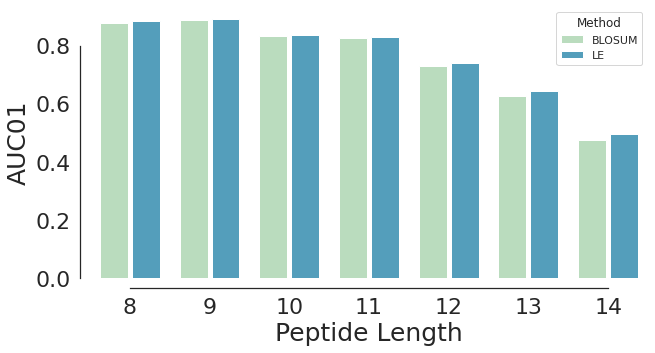

In [21]:
sns.set(rc = {'figure.figsize':(10,5)})

sns.set(style='white')
sns.barplot(x='Peptide Length', y='AUC01', hue='Method', data=concat, palette = 'GnBu')

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=25)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=25)

sn.set(font_scale=2)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        patch.set_width(new_value)

        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)

sn.despine(offset=10, trim=True)


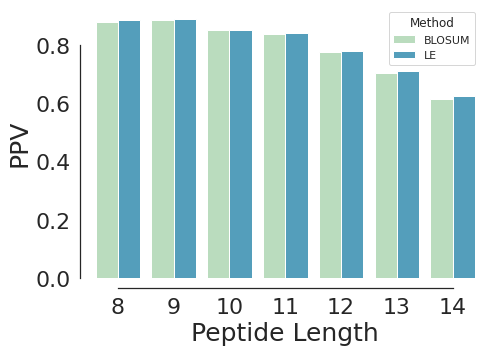

In [72]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(style='white')

sns.barplot(x='Peptide Length', y='PPV', hue='Method', data=concat, palette = 'GnBu')

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=25)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=25)

sn.set(font_scale=2)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)

sn.despine(offset=10, trim=True)


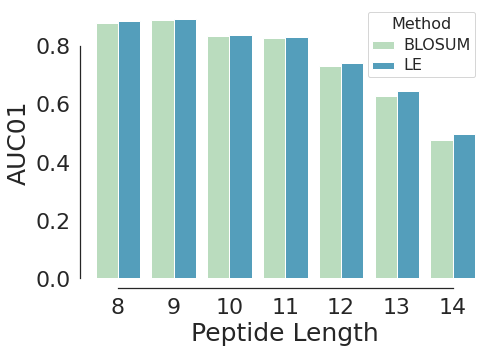

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(7,5)})
#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Peptide Length', y='AUC01', hue='Method', data=concat, palette = 'GnBu')

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=16)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=16)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=25)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=25)

sn.set(font_scale=2)

sn.despine(offset=10, trim=True)


BLOSUM-20	0.952049	0.965490	0.975266	0.977627	0.978337	0.979500
  embd-4	0.896574	0.952302	0.971601	0.974795	0.976814	0.977345
  embd-20	0.947010	0.966847	0.977170	0.979466	0.980489	0.981001
  embd-32	0.946269	0.966373	0.976074	0.978787	0.980202	0.980599
  embd-64	0.947829	0.965276	0.975379	0.977908	0.979261	0.980087